## Evaluate NCES

In [ ]:
import os, random
kg_path_semb = "Method/Datasets/semantic_bible/semantic_bible.owl"

kg_path_fam = "Method/Datasets/family-benchmark/family-benchmark_rich_background.owl"

kg_path_car = "Method/Datasets/carcinogenesis/carcinogenesis.owl"

kg_path_mut = "Method/Datasets/mutagenesis/mutagenesis.owl"

kg_path_vic = "Method/Datasets/vicodi/vicodi.owl"

In [ ]:
from Method.helper_classes.syntax_checker import SyntaxChecker
from Method.ontolearn import KnowledgeBase
from Method.concept_synthesis.helper_classes import ConceptSynthesizer
from Method.base.base_concept_synthetizer import BaseConceptSynthesis

In [ ]:
from util.data import Data

In [ ]:
path_to_triples = "Method/Datasets/semantic_bible/Triples/"
triples = Data({"path_to_triples":path_to_triples})
max_num_atom_repeat = 10
kwargs_semb = {"learner_name":"GRU", "emb_model_name":"", 'knowledge_graph_path': kg_path_semb,
           "pretrained_embedding_path":"Method/Datasets/semantic_bible/Model_weights/ConEx_GRU.pt",
           "pretrained_concept_synthesizer":"Method/Datasets/semantic_bible/Model_weights/GRU.pt", 
           "path_to_csv_embeddings":"Method/Embeddings/semantic_bible/ConEx_entity_embeddings.csv",
           "learning_rate":0.001, "decay_rate":0, "path_to_triples":path_to_triples, 'max_num_atom_repeat': max_num_atom_repeat,
           'index_score_upper_bound':10., 'index_score_lower_bound_rate': 0.8, 'max_num_tokens':30,
           "random_seed":1, "embedding_dim":20, "num_entities":len(triples.entities),
           "num_relations":len(triples.relations), "num_examples":362, "input_dropout":0.0, 'drop_prob':0.1,
           "kernel_size":4, "num_of_output_channels":8, "feature_map_dropout":0.1,
           "hidden_dropout":0.1, "rnn_n_layers":2, 'input_size':40,
           'rnn_n_hidden':100,'seed':10, 'kernel_w':5, 'kernel_h':11, 'stride_w':1, 'stride_h':7, 'conv_out':1408}

path_to_triples = "Method/Datasets/family-benchmark/Triples/"
triples = Data({"path_to_triples":path_to_triples})
max_num_atom_repeat = 15
kwargs_fam = {"learner_name":"GRU", "emb_model_name":"", 'knowledge_graph_path': kg_path_fam,
          "pretrained_embedding_path":"Method/Datasets/family-benchmark/Model_weights/ConEx_GRU.pt",
          "pretrained_concept_synthesizer":"Method/Datasets/family-benchmark/Model_weights/GRU.pt", 
          "path_to_csv_embeddings":"Method/Embeddings/family-benchmark/ConEx_entity_embeddings.csv",
          "learning_rate":0.001, "decay_rate":0, 'grad_clip_value':5., "path_to_triples":path_to_triples, 'max_num_atom_repeat': max_num_atom_repeat,
          'index_score_upper_bound':10., 'index_score_lower_bound_rate': 0.8, 'max_num_tokens':30,
          "random_seed":1, "embedding_dim":20, "num_entities":len(triples.entities),
          "num_relations":len(triples.relations), "num_examples":101, "input_dropout":0.0, 'drop_prob':0.1,
          "kernel_size":4, "num_of_output_channels":8, "feature_map_dropout":0.1,
          "hidden_dropout":0.1, "rnn_n_layers":2, 'input_size':40,
          'rnn_n_hidden':100,'seed':10, 'kernel_w':5, 'kernel_h':11, 'stride_w':1, 'stride_h':2, 'conv_out':576}

path_to_triples = "Method/Datasets/carcinogenesis/Triples/"
max_num_atom_repeat = 10
path_to_triples = Data({"path_to_triples":path_to_triples})
kwargs_car = {"learner_name":"GRU", "emb_model_name":"", 'knowledge_graph_path': kg_path_car,
           "pretrained_embedding_path":"Method/Datasets/carcinogenesis/Model_weights/ConEx_GRU.pt",
           "pretrained_concept_synthesizer":"Method/Datasets/carcinogenesis/Model_weights/GRU.pt", 
           "path_to_csv_embeddings":"Method/Embeddings/carcinogenesis/ConEx_entity_embeddings.csv",
           "learning_rate":0.001, "decay_rate":0, 'grad_clip_value':5., "path_to_triples":path_to_triples, 'max_num_atom_repeat': max_num_atom_repeat,
           'index_score_upper_bound':10., 'index_score_lower_bound_rate': 0.8, 'max_num_tokens':30,
           "random_seed":1, "embedding_dim":20, "num_entities":len(triples.entities),
           "num_relations":len(triples.relations), "num_examples":1000, "input_dropout":0.0, 'drop_prob':0.1,
           "kernel_size":4, "num_of_output_channels":8, "feature_map_dropout":0.1,
           "hidden_dropout":0.1, "rnn_n_layers":2, 'input_size':40,
           'rnn_n_hidden':100,'seed':10, 'kernel_w':5, 'kernel_h':11, 'stride_w':1, 'stride_h':7, 'conv_out':960}

path_to_triples = "Method/Datasets/mutagenesis/Triples/"
max_num_atom_repeat = 10
triples = Data({"path_to_triples":path_to_triples})
kwargs_mut = {"learner_name":"GRU", "emb_model_name":"", 'knowledge_graph_path': kg_path_mut,
          "pretrained_embedding_path":"Method/Datasets/mutagenesis/Model_weights/ConEx_GRU.pt",
          "pretrained_concept_synthesizer":"Method/Datasets/mutagenesis/Model_weights/GRU.pt", 
          "path_to_csv_embeddings":"Method/Embeddings/mutagenesis/ConEx_entity_embeddings.csv",
          "learning_rate":0.001, "decay_rate":0., 'grad_clip_value':5., "path_to_triples":path_to_triples, 'max_num_atom_repeat': max_num_atom_repeat,
          'index_score_upper_bound':10., 'index_score_lower_bound_rate': 0.8, 'max_num_tokens':30,
          "random_seed":1, "embedding_dim":20, "num_entities":len(triples.entities),
          "num_relations":len(triples.relations), "num_examples":1000, "input_dropout":0.0, 'drop_prob':0.1,
          "kernel_size":4, "num_of_output_channels":8, "feature_map_dropout":0.1,
          "hidden_dropout":0.1, "rnn_n_layers":2, 'input_size':40,
          'rnn_n_hidden':100,'seed':10, 'kernel_w':5, 'kernel_h':11, 'stride_w':1, 'stride_h':7, 'conv_out':960}

path_to_triples = "Method/Datasets/vicodi/Triples/"
max_num_atom_repeat = 10
triples = Data({"path_to_triples":path_to_triples})
kwargs_vic = {"learner_name":"GRU", "emb_model_name":"", 'knowledge_graph_path': kg_path_vic,
          "pretrained_embedding_path":"Method/Datasets/vicodi/Model_weights/ConEx_GRU.pt",
          "pretrained_concept_synthesizer":"Method/Datasets/vicodi/Model_weights/GRU.pt", 
          "path_to_csv_embeddings":"Method/Embeddings/vicodi/ConEx_entity_embeddings.csv",
          "learning_rate":0.001, "decay_rate":0., 'grad_clip_value':5., "path_to_triples":path_to_triples, 'max_num_atom_repeat': max_num_atom_repeat,
          'index_score_upper_bound':10., 'index_score_lower_bound_rate': 0.8, 'max_num_tokens':30,
          "random_seed":1, "embedding_dim":20, "num_entities":len(triples.entities),
          "num_relations":len(triples.relations), "num_examples":1000, "input_dropout":0.0, 'drop_prob':0.1,
          "kernel_size":4, "num_of_output_channels":8, "feature_map_dropout":0.1,
          "hidden_dropout":0.1, "rnn_n_layers":2, 'input_size':40,
          'rnn_n_hidden':100,'seed':10, 'kernel_w':5, 'kernel_h':11, 'stride_w':1, 'stride_h':7, 'conv_out':960}

In [ ]:
import json
from sklearn.model_selection import train_test_split

lp_path_semb = "Method/Datasets/semantic_bible/Train_data/Data.json"
with open(lp_path_semb,"r") as lp_file:
    data_semb = json.load(lp_file)
    
lp_path_fam = "Method/Datasets/family-benchmark/Train_data/Data.json"
with open(lp_path_fam,"r") as lp_file:
    data_fam = json.load(lp_file)
    
lp_path_car = "Method/Datasets/carcinogenesis/Train_data/Data.json"
with open(lp_path_car,"r") as lp_file:
    data_car = json.load(lp_file)
    
lp_path_mut = "Method/Datasets/mutagenesis/Train_data/Data.json"
with open(lp_path_mut,"r") as lp_file:
    data_mut = json.load(lp_file)
    
lp_path_vic = "Method/Datasets/vicodi/Train_data/Data.json"
with open(lp_path_vic,"r") as lp_file:
    data_vic = json.load(lp_file)
    
random.seed(142) #for reproducible results

data_mut = list(data_mut.items())
_, data_test_mut = train_test_split(data_mut, test_size=0.2, random_state=123)
data_test_mut = random.sample(data_test_mut, 200)

data_car = list(data_car.items())
_, data_test_car = train_test_split(data_car, test_size=0.2, random_state=123)
data_test_car = random.sample(data_test_car, 200)

data_semb = list(data_semb.items())
_, data_test_semb = train_test_split(data_semb, test_size=0.2, random_state=123)
data_test_semb = random.sample(data_test_semb, 200)

data_fam = list(data_fam.items())
_, data_test_fam = train_test_split(data_fam, test_size=0.2, random_state=123)
data_test_fam = random.sample(data_test_fam, 200)

data_vic = list(data_vic.items())
_, data_test_vic = train_test_split(data_vic, test_size=0.2, random_state=123)
data_test_vic = random.sample(data_test_vic, 200)

In [ ]:
import numpy as np, time
from collections import defaultdict

In [ ]:
def compute_accuracy(prediction:str, target:str):
    def soft(arg1, arg2):
        arg1_ = set(BaseConceptSynthesis.decompose(arg1)) - {' '}
        arg2_ = set(BaseConceptSynthesis.decompose(arg2)) - {' '}
        return 100*float(len(arg1_.intersection(arg2_)))/max(1, len(arg1_.union(arg2_)))

    def hard(arg1, arg2):
        arg1_ = BaseConceptSynthesis.decompose(arg1)
        arg2_ = BaseConceptSynthesis.decompose(arg2)
        return 100*float(sum(map(lambda x,y: x==y, arg1_, arg2_)))/max(1, len(arg1_), len(arg2_))
    soft_acc = sum(map(soft, prediction, target))/len(target)
    hard_acc = sum(map(hard, prediction, target))/len(target)
    return soft_acc, hard_acc

In [ ]:
def evaluate_nces(kg_path, kg_kwargs, data_test, kg_name, verbose=False,  shuffle_examples=False):
    print('#'*50)
    print('NCES evaluation on {} KG:'.format(kg_name))
    print('#'*50)
    All_metrics = {'LSTM':defaultdict(lambda: defaultdict(list)), 'GRU':defaultdict(lambda: defaultdict(list)),\
                   'CNN':defaultdict(lambda: defaultdict(list))}
    for synthesizer_name in ['LSTM', 'GRU', 'CNN']:
        kg = KnowledgeBase(path=kg_path)
        kg_kwargs["pretrained_concept_synthesizer"] = "Method/Datasets/"+kg_name+"/Model_weights/"+synthesizer_name+".pt"
        synthesizer = ConceptSynthesizer(kg_kwargs)
        syntax_checker = SyntaxChecker(kg)
        best_pred = ''
        for pb_str, pb in data_test:
            pos_examples = pb['positive examples']
            if shuffle_examples:
                random.shuffle(pos_examples)
            t0 = time.time()
            pred_sequence, _ = synthesizer.predict(pos_examples)
            try:
                best_pred, acc, f1 = syntax_checker.concept(pred_sequence[0]).evaluate(pos_examples, verbose=verbose)
                duration = time.time()-t0
                All_metrics[synthesizer_name]['acc']['values'].append(acc)
                All_metrics[synthesizer_name]['prediction']['values'].append(best_pred)
                All_metrics[synthesizer_name]['f1']['values'].append(f1)
#                str_acc = compute_accuracy(best_pred, pb_str)[1]
#                All_metrics[synthesizer_name]['str_acc']['values'].append(str_acc)
                
            except Exception:
                print('Could not understand expression: {}'.format(syntax_checker.correct(pred_sequence[0])))
                duration = time.time()-t0
                All_metrics[synthesizer_name]['acc']['values'].append(0.0)
                All_metrics[synthesizer_name]['prediction']['values'].append('None')
                All_metrics[synthesizer_name]['f1']['values'].append(0.0)
#                All_metrics[synthesizer_name]['str_acc']['values'].append(0)
            All_metrics[synthesizer_name]['time']['values'].append(duration)
        
        All_metrics[synthesizer_name]['acc']['mean'] = [np.mean(All_metrics[synthesizer_name]['acc']['values'])]
        All_metrics[synthesizer_name]['acc']['std'] = [np.std(All_metrics[synthesizer_name]['acc']['values'])]
        All_metrics[synthesizer_name]['f1']['mean'] = [np.mean(All_metrics[synthesizer_name]['f1']['values'])]
        All_metrics[synthesizer_name]['f1']['std'] = [np.std(All_metrics[synthesizer_name]['f1']['values'])]
        All_metrics[synthesizer_name]['time']['mean'] = [np.mean(All_metrics[synthesizer_name]['time']['values'])]
        All_metrics[synthesizer_name]['time']['std'] = [np.std(All_metrics[synthesizer_name]['time']['values'])]
#        All_metrics[synthesizer_name]['str_acc']['mean'] = [np.mean(All_metrics[synthesizer_name]['str_acc']['values'])]
#        All_metrics[synthesizer_name]['str_acc']['std'] = [np.std(All_metrics[synthesizer_name]['str_acc']['values'])]
        
        print(synthesizer_name+' Speed: {}s +- {} / lp'.format(round(All_metrics[synthesizer_name]['time']['mean'][0], 2),\
                                                               round(All_metrics[synthesizer_name]['time']['std'][0], 2)))
        print(synthesizer_name+' Avg Acc: {}% +- {} / lp'.format(round(All_metrics[synthesizer_name]['acc']['mean'][0], 2),\
                                                               round(All_metrics[synthesizer_name]['acc']['std'][0], 2)))
        print(synthesizer_name+' Avg F1: {}% +- {} / lp'.format(round(All_metrics[synthesizer_name]['f1']['mean'][0], 2),\
                                                               round(All_metrics[synthesizer_name]['f1']['std'][0], 2)))
#        print(synthesizer_name+' Avg Str_Acc: {}% +- {} / lp'.format(round(All_metrics[synthesizer_name]['str_acc']['mean'][0], 2),\
#                                                               round(All_metrics[synthesizer_name]['str_acc']['std'][0], 2)))
#        print("\n")
        
        with open("Method/Datasets/"+kg_name+"/Results/NCES.json", "w") as file:
            json.dump(All_metrics, file, indent=3, ensure_ascii=False)
    return All_metrics

In [ ]:
F1_semb = evaluate_nces(kg_path_semb, kwargs_semb, data_test_semb, 'semantic_bible')

In [ ]:
F1_car = evaluate_nces(kg_path_car, kwargs_car, data_test_car, 'carcinogenesis', verbose=False)

In [ ]:
F1_fam = evaluate_nces(kg_path_fam, kwargs_fam, data_test_fam, 'family-benchmark', verbose=False)

In [ ]:
F1_mut = evaluate_nces(kg_path_mut, kwargs_mut, data_test_mut, 'mutagenesis', verbose=False)

In [ ]:
F1_vic = evaluate_nces(kg_path_vic, kwargs_vic, data_test_vic, 'vicodi', verbose=False)

## Shuffle positive examples

In [10]:
#F1_semb_rand = evaluate_nces(kg_path_semb, kwargs_semb, data_test_semb, 'semantic_bible', verbose=False, shuffle_examples=True)

In [11]:
#F1_car_rand = evaluate_nces(kg_path_car, kwargs_car, data_test_car, 'carcinogenesis', verbose=False, shuffle_examples=True)

In [12]:
#F1_fam_rand = evaluate_nces(kg_path_fam, kwargs_fam, data_test_fam, 'family-benchmark', verbose=False, shuffle_examples=True)

In [13]:
#F1_mut_rand = evaluate_nces(kg_path_mut, kwargs_mut, data_test_mut, 'mutagenesis', verbose=False, shuffle_examples=True)

In [ ]:
#F1_car_rand['LSTM'][31]

## Statistical tests

In [5]:
from Method.helper_functions import wilcoxon_statistical_test
import warnings
warnings.filterwarnings('ignore')
import json

def celoe_vs_nces_stat_tests():
    with open('Method/Datasets/semantic_bible/Results/NCES.json') as file:
        nces = json.load(file)
    f1_nces = nces['LSTM']['f1']['values']
    acc_nces = nces['LSTM']['acc']['values']
    time_nces = nces['LSTM']['time']['values']
    with open('Method/Datasets/semantic_bible/Results/concept_learning_results_celoe.json') as celoe_file:
        celoe = json.load(celoe_file)
    f1_celoe = celoe['F-measure']
    acc_celoe = celoe['Accuracy']
    time_celoe = celoe['Runtime']
    _, p1 = wilcoxon_statistical_test(acc_nces, acc_celoe)
    _, p2 = wilcoxon_statistical_test(f1_nces, f1_celoe)
    _, p3 = wilcoxon_statistical_test(time_nces, time_celoe)
    for metric, p in zip(['Accuracy', 'F1', 'RunTime'], [p1,p2,p3]):
        print(f'On {metric} of Semantic Bible KG, p_value = ', p)
        if p<=0.05:
            print('Probably different distributions')
        else:
            print('Probably the same distribution')
        print()
    
    with open('Method/Datasets/family-benchmark/Results/NCES.json') as file:
        nces = json.load(file)
    f1_nces = nces['LSTM']['f1']['values']
    acc_nces = nces['LSTM']['acc']['values']
    time_nces = nces['LSTM']['time']['values']
    with open('Method/Datasets/family-benchmark/Results/concept_learning_results_celoe.json') as celoe_file:
        celoe = json.load(celoe_file)
    f1_celoe = celoe['F-measure']
    acc_celoe = celoe['Accuracy']
    time_celoe = celoe['Runtime']
    _, p1 = wilcoxon_statistical_test(acc_nces, acc_celoe)
    _, p2 = wilcoxon_statistical_test(f1_nces, f1_celoe)
    _, p3 = wilcoxon_statistical_test(time_nces, time_celoe)
    for metric, p in zip(['Accuracy', 'F1', 'RunTime'], [p1,p2,p3]):
        print(f'On {metric} of Family Benchmark KG, p_value = ', p)
        if p<=0.05:
            print('Probably different distributions')
        else:
            print('Probably the same distribution')
        print()
        
    with open('Method/Datasets/mutagenesis/Results/NCES.json') as file:
        nces = json.load(file)
    f1_nces = nces['LSTM']['f1']['values']
    acc_nces = nces['LSTM']['acc']['values']
    time_nces = nces['LSTM']['time']['values']
    with open('Method/Datasets/mutagenesis/Results/concept_learning_results_celoe.json') as celoe_file:
        celoe = json.load(celoe_file)
    f1_celoe = celoe['F-measure']
    acc_celoe = celoe['Accuracy']
    time_celoe = celoe['Runtime']
    _, p1 = wilcoxon_statistical_test(acc_nces, acc_celoe)
    _, p2 = wilcoxon_statistical_test(f1_nces, f1_celoe)
    _, p3 = wilcoxon_statistical_test(time_nces, time_celoe)
    for metric, p in zip(['Accuracy', 'F1', 'RunTime'], [p1,p2,p3]):
        print(f'On {metric} of Mutagenesis KG, p_value = ', p)
        if p<=0.05:
            print('Probably different distributions')
        else:
            print('Probably the same distribution')
        print()
        
    with open('Method/Datasets/carcinogenesis/Results/NCES.json') as file:
        nces = json.load(file)
    f1_nces = nces['LSTM']['f1']['values']
    acc_nces = nces['LSTM']['acc']['values']
    time_nces = nces['LSTM']['time']['values']
    with open('Method/Datasets/carcinogenesis/Results/concept_learning_results_celoe.json') as celoe_file:
        celoe = json.load(celoe_file)
    f1_celoe = celoe['F-measure']
    acc_celoe = celoe['Accuracy']
    time_celoe = celoe['Runtime']
    _, p1 = wilcoxon_statistical_test(acc_nces, acc_celoe)
    _, p2 = wilcoxon_statistical_test(f1_nces, f1_celoe)
    _, p3 = wilcoxon_statistical_test(time_nces, time_celoe)
    for metric, p in zip(['Accuracy', 'F1', 'RunTime'], [p1,p2,p3]):
        print(f'On {metric} of Carcinogenesis KG, p_value = ', p)
        if p<=0.05:
            print('Probably different distributions')
        else:
            print('Probably the same distribution')
        print()
        
    with open('Method/Datasets/vicodi/Results/NCES.json') as file:
        nces = json.load(file)
    f1_nces = nces['LSTM']['f1']['values']
    acc_nces = nces['LSTM']['acc']['values']
    time_nces = nces['LSTM']['time']['values']
    with open('Method/Datasets/vicodi/Results/concept_learning_results_celoe.json') as celoe_file:
        celoe = json.load(celoe_file)
    f1_celoe = celoe['F-measure']
    acc_celoe = celoe['Accuracy']
    time_celoe = celoe['Runtime']
    _, p1 = wilcoxon_statistical_test(acc_nces, acc_celoe)
    _, p2 = wilcoxon_statistical_test(f1_nces, f1_celoe)
    _, p3 = wilcoxon_statistical_test(time_nces, time_celoe)
    for metric, p in zip(['Accuracy', 'F1', 'RunTime'], [p1,p2,p3]):
        print(f'On {metric} of Vicodi KG, p_value = ', p)
        if p<=0.05:
            print('Probably different distributions')
        else:
            print('Probably the same distribution')
        print()

In [6]:
celoe_vs_nces_stat_tests()

stat=45.000, p=0.000
Probably different distributions
stat=171.000, p=0.000
Probably different distributions
stat=14.000, p=0.000
Probably different distributions
On Accuracy of Semantic Bible KG, p_value =  2.778608411556193e-34
Probably different distributions

On F1 of Semantic Bible KG, p_value =  1.8136514710328702e-33
Probably different distributions

On RunTime of Semantic Bible KG, p_value =  1.7729943823825292e-34
Probably different distributions

stat=1.000, p=0.000
Probably different distributions
stat=21.000, p=0.000
Probably different distributions
stat=0.000, p=0.000
Probably different distributions
On Accuracy of Family Benchmark KG, p_value =  1.4579385692155708e-34
Probably different distributions

On F1 of Family Benchmark KG, p_value =  1.9697375762277328e-34
Probably different distributions

On RunTime of Family Benchmark KG, p_value =  1.4361464127613523e-34
Probably different distributions

stat=1.000, p=0.000
Probably different distributions
stat=231.000, p=0.000

## Training curves

In [13]:
import json
plt_data_path = "Method/Datasets/semantic_bible/Plot_data/plot_data.json"
with open(plt_data_path,"r") as plt_file1:
    plt_data1 = json.load(plt_file1)

plt_data_path = "Method/Datasets/family-benchmark/Plot_data/plot_data.json"
with open(plt_data_path,"r") as plt_file2:
    plt_data2 = json.load(plt_file2)
    
    
plt_data_path = "Method/Datasets/carcinogenesis/Plot_data/plot_data.json"
with open(plt_data_path,"r") as plt_file3:
    plt_data3 = json.load(plt_file3)

plt_data_path = "Method/Datasets/mutagenesis/Plot_data/plot_data.json"
with open(plt_data_path,"r") as plt_file4:
    plt_data4 = json.load(plt_file4)
    
plt_data_path = "Method/Datasets/vicodi/Plot_data/plot_data.json"
with open(plt_data_path,"r") as plt_file5:
    plt_data5 = json.load(plt_file5)

import matplotlib.pyplot as plt

In [14]:
plt_data1.keys()

dict_keys(['soft acc', 'hard acc', 'loss'])

In [15]:
def plot_curves(plt_data1, plt_data2, name1, name2):

    Markers = ['--', ':', '-']
    Colors = ['g', 'b', 'm']
    i = 0
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,7))
    #fig.suptitle('Sharing x per column, y per row')

    for crv in plt_data1['loss']:
        mk = Markers[i%3]
        c = Colors[i%3]
        ax1.plot(crv, mk, markersize=5, color=c)
        i += 1
    ax1.legend(('GRU', 'LSTM', 'CNN'))
    ax1.set_title(name1)
    ax1.set(ylabel='Loss')

    for crv in plt_data2['loss']:
        mk = Markers[i%3]
        c = Colors[i%3]
        ax2.plot(crv, mk, markersize=5, color=c)
        i += 1   
    ax2.legend(('GRU', 'LSTM', 'CNN'))
    ax2.set_title(name2)

    for crv in plt_data1['hard acc']:
        mk = Markers[i%3]
        c = Colors[i%3]
        ax3.plot(crv, mk, markersize=5, color=c)
        i += 1
    ax3.legend(('GRU', 'LSTM', 'CNN'))
    ax3.set(ylabel='Hard Accuracy', xlabel='Epochs')    

    for crv in plt_data2['hard acc']:
        mk = Markers[i%3]
        c = Colors[i%3]
        ax4.plot(crv, mk, markersize=5, color=c)
        i += 1
    ax4.legend(('GRU', 'LSTM', 'CNN'))
    ax4.set(xlabel='Epochs')    

    for ax in fig.get_axes():
        ax.label_outer()
    fig.savefig('training-curves'+name1+'_and_'+name2+'.pdf')
    fig.show()

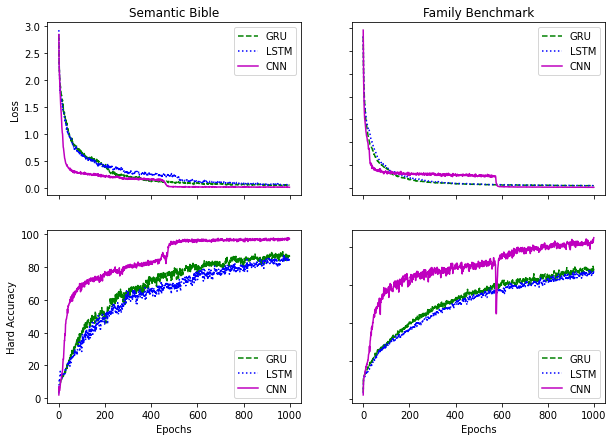

In [16]:
plot_curves(plt_data1, plt_data2, name1='Semantic Bible', name2='Family Benchmark')

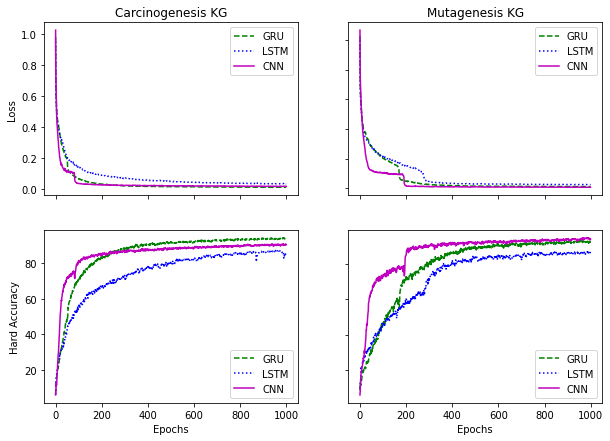

In [43]:
plot_curves(plt_data3, plt_data4, name1='Carcinogenesis', name2='Mutagenesis')

In [17]:
def plot_acc_curves(plt_data1, plt_data2, plt_data3, plt_data4, plt_data5, name1, name2, name3, name4, name5, mode='hard'):

    Markers = ['--', ':', '-']
    Colors = ['g', 'b', 'm']
    i = 0
    fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(30,6), sharey=True)
    #fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,5), sharey=True, sharex=True)
    #fig.suptitle('Sharing x per column, y per row')

    for crv in plt_data1[f'{mode} acc']:
        mk = Markers[i%3]
        c = Colors[i%3]
        ax1.plot(crv, mk, markersize=6, color=c)
        i += 1
    leg1 = ax1.legend(('GRU', 'LSTM', 'CNN'), prop={'size': 20})
    for line in leg1.get_lines():
        line.set_linewidth(4.0)
    ax1.set_title(name1, fontsize=30, fontweight="bold")
    ax1.set_xlabel('Epochs', fontsize=25)
    ax1.set_ylabel(mode.capitalize()+' Accuracy', fontsize=25)
    ax1.tick_params(axis='both', which='major', labelsize=20)

    for crv in plt_data2[f'{mode} acc']:
        mk = Markers[i%3]
        c = Colors[i%3]
        ax2.plot(crv, mk, markersize=6, color=c)
        i += 1   
    leg2 = ax2.legend(('GRU', 'LSTM', 'CNN'), prop={'size': 20})
    for line in leg2.get_lines():
        line.set_linewidth(4.0)
    ax2.set_title(name2, fontsize=30, fontweight="bold")
    ax2.set_xlabel('Epochs', fontsize=25)
    ax2.tick_params(axis='both', which='major', labelsize=20)

    for crv in plt_data3[f'{mode} acc']:
        mk = Markers[i%3]
        c = Colors[i%3]
        ax3.plot(crv, mk, markersize=10, color=c)
        i += 1
    leg3 = ax3.legend(('GRU', 'LSTM', 'CNN'), prop={'size': 20})
    for line in leg3.get_lines():
        line.set_linewidth(4.0)
    ax3.set_title(name3, fontsize=30, fontweight="bold")
    ax3.set_xlabel('Epochs', fontsize=25)
    ax3.tick_params(axis='both', which='major', labelsize=20)

    for crv in plt_data4[f'{mode} acc']:
        mk = Markers[i%3]
        c = Colors[i%3]
        ax4.plot(crv, mk, markersize=10, color=c)
        i += 1
    leg4 = ax4.legend(('GRU', 'LSTM', 'CNN'), prop={'size': 20})
    for line in leg4.get_lines():
        line.set_linewidth(4.0)
    ax4.set_xlabel('Epochs', fontsize=25)
    ax4.set_title(name4, fontsize=30, fontweight="bold")
    ax4.tick_params(axis='both', which='major', labelsize=20)
    
    for crv in plt_data5[f'{mode} acc']:
        mk = Markers[i%3]
        c = Colors[i%3]
        ax5.plot(crv, mk, markersize=10, color=c)
        i += 1
    
    leg5 = ax5.legend(('GRU', 'LSTM', 'CNN'), prop={'size': 20})
    for line in leg5.get_lines():
        line.set_linewidth(4.0)
    ax5.set_xlabel('Epochs', fontsize=25)
    ax5.set_title(name5, fontsize=30, fontweight="bold")
    ax5.tick_params(axis='both', which='major', labelsize=20)

    for ax in fig.get_axes():
        ax.label_outer()
    fig.savefig(f'accuracy-curves-all-KGs_{mode}.pdf', bbox_inches='tight')
    fig.show()

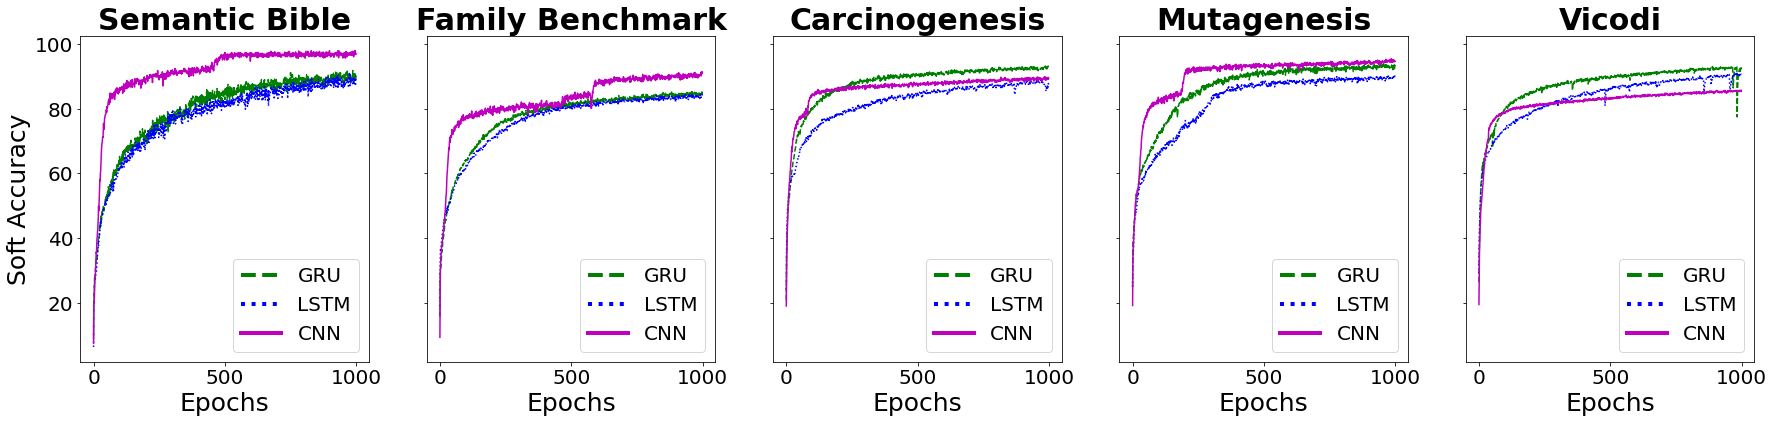

In [18]:
name1, name2, name3, name4, name5 = 'Semantic Bible', 'Family Benchmark', 'Carcinogenesis', 'Mutagenesis', 'Vicodi'
plot_acc_curves(plt_data1, plt_data2, plt_data3, plt_data4, plt_data5, name1, name2, name3, name4, name5, mode='soft')